## MIST demo

This notebook is a variation of the quickstart guide that walks through various model functionalities. 

In [2]:
import pandas as pd
from pathlib import Path
import copy

import numpy as np
import torch
from tqdm import tqdm
import pickle

from mist.utils.plot_utils import *
from rdkit import Chem
from rdkit.Chem import Draw

import mist.utils as utils
import mist.subformulae.assign_subformulae as assign_subformulae
import mist.models.base as base
import mist.data.datasets as datasets
import mist.data.featurizers as featurizers
import mist.data.data as data

## Define constants

In [3]:
# Make sure to predownload the pretrained models by following quickstart/
fp_ckpt="../pretrained_models/mist_fp_canopus_pretrain.ckpt"
contrast_ckpt="../pretrained_models/mist_contrastive_canopus_pretrain.ckpt"

In [4]:
res_dir = "../results/demo_mist/"
mgf_input = "../quickstart/quickstart.mgf"
labels = "../quickstart/quickstart_labels.tsv"
smiles_input = "../quickstart/lookup_smiles.txt"

res_dir = Path(res_dir)
res_dir.mkdir(exist_ok=True)


## Assign subforms for preprocessing

In [5]:

subform_dir=res_dir/"subforms"
subform_dir.mkdir(exist_ok=True,parents=True)

assign_subformulae.assign_subforms(
    spec_files=mgf_input,
    labels_file=labels,
    output_dir=subform_dir,
    mass_diff_thresh=20,
    max_formulae=50,
    num_workers=32,
    feature_id="FEATURE_ID",
    debug=False
)

28it [00:00, 6039.63it/s]

There are 5 spec-cand pairs this spec files



5it [00:00, 3795.06it/s]


## Fingerprint prediction

In [6]:
fp_save_dir = res_dir / "model_predictions"
fp_save_dir.mkdir(exist_ok=True, parents=True)

fp_model = torch.load(fp_ckpt, map_location=torch.device("cpu"))

main_hparams = fp_model["hyper_parameters"]
kwargs = copy.deepcopy(main_hparams)
kwargs['device'] = "cpu"
kwargs['num_workers'] = 0
kwargs['subform_folder'] = subform_dir
kwargs['labels_file'] = labels

device = torch.device("cpu")
model = base.build_model(**kwargs)

model.load_state_dict(fp_model["state_dict"])
model = model.to(device)
model = model.eval()

kwargs["spec_features"] = model.spec_features(mode="test")
kwargs['mol_features'] = "none"
kwargs['allow_none_smiles'] = True

paired_featurizer = featurizers.get_paired_featurizer(**kwargs)

# Ignore errors; we're just using this to get the featurizer
spectra_mol_pairs = datasets.get_paired_spectra(**kwargs)
spectra_mol_pairs = list(zip(*spectra_mol_pairs))

5it [00:00, 26247.21it/s]
5it [00:00, 16082.45it/s]
5it [00:00, 40329.85it/s]


In [7]:
test_dataset = datasets.SpectraMolDataset(
    spectra_mol_list=spectra_mol_pairs, featurizer=paired_featurizer, **kwargs
)
output_preds = (
    model.encode_all_spectras(test_dataset, no_grad=True, **kwargs).cpu().numpy()
)
output_names = test_dataset.get_spectra_names()

In [8]:
output_preds.sum(-1), output_preds.max(-1), output_preds.min(-1), output_preds.mean(-1)

(array([14.175489, 24.028225, 18.76162 , 20.334423, 14.798999],
       dtype=float32),
 array([0.61718476, 0.9472583 , 0.83603144, 0.8346735 , 0.81241995],
       dtype=float32),
 array([1.1067550e-12, 1.3864350e-13, 1.5090297e-12, 3.3801864e-11,
        2.1115909e-12], dtype=float32),
 array([0.00346081, 0.00586627, 0.00458047, 0.00496446, 0.00361304],
       dtype=float32))

Text(0, 0.5, 'Spectrum')

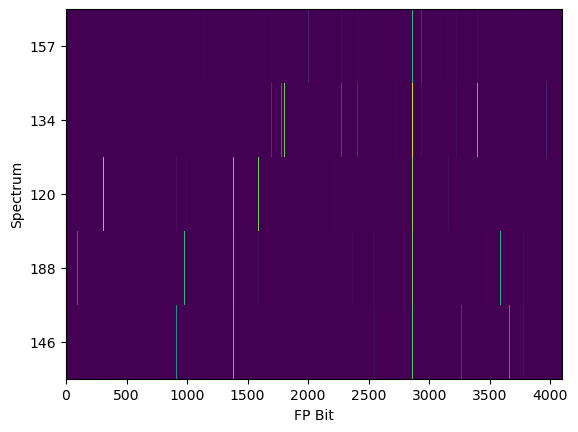

In [9]:
plt.imshow(output_preds, cmap="viridis", aspect="auto", interpolation="nearest");
plt.yticks(np.arange(len(output_preds)), output_names); #rotation=90)
plt.xlabel("FP Bit")
plt.ylabel("Spectrum")

In [10]:
result_export = {
    "dataset_name": "quickstart",
    "names": output_names,
    "preds": output_preds,
    "targs": [None] * len(output_names),
    "args": kwargs,
    "split_name": "",
}
results_name = f"fp_preds_quickstart.p"
save_loc = Path(fp_save_dir).joinpath(results_name)
with open(save_loc, "wb") as fp:
    pickle.dump(result_export, fp)

## Contrastive embedding

In [11]:
contrast_savedir = Path("../quickstart/model_predictions")
contrast_model = torch.load(contrast_ckpt, map_location=torch.device("cpu"))
contrast_savedir.mkdir(exist_ok=True)

main_hparams = contrast_model["hyper_parameters"]
main_hparams['labels_file'] = labels
main_hparams['device'] = "cpu"
main_hparams['allow_none_smiles'] = True
main_hparams['num_workers'] = 0
main_hparams['subform_folder'] = subform_dir

base_params = main_hparams["base_model_hparams"]
main_hparams["base_model_hparams"] = copy.deepcopy(base_params)
base_params.update(main_hparams)
kwargs = base_params

device = torch.device("cpu")
model = base.build_model(**kwargs)
model.load_state_dict(contrast_model["state_dict"])
model = model.to(device)
model = model.eval()

kwargs["spec_features"] = model.main_model.spec_features(mode="test")
kwargs['mol_features'] = "none"

paired_featurizer = featurizers.get_paired_featurizer(**kwargs)

# Ignore errors; we're just using this to get the featurizer
spectra_mol_pairs = datasets.get_paired_spectra(**kwargs)
spectra_mol_pairs = list(zip(*spectra_mol_pairs))

5it [00:00, 53911.36it/s]
5it [00:00, 17863.30it/s]
5it [00:00, 31536.12it/s]


In [12]:
test_dataset = datasets.SpectraMolDataset(
    spectra_mol_list=spectra_mol_pairs, featurizer=paired_featurizer, **kwargs
)

test_loader = datasets.SpecDataModule.get_paired_loader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=kwargs.get("num_workers"),
)

# Encode specs
encoded_specs, names = [], []
with torch.no_grad():
    model = model.to(device)
    model = model.eval()
    for spectra_batch in tqdm(test_loader):
        spectra_batch = {
            k: v.to(device=device, non_blocking=True) if hasattr(v, "to") else v
            for k, v in spectra_batch.items()
        }
        outputs = model.encode_spectra(spectra_batch)
        contrast_out = outputs[1]["contrast"].detach().cpu()
        encoded_specs.append(contrast_out)
        names.append(spectra_batch["names"])

    names = np.concatenate(names)
    stacked_spectra = torch.cat(encoded_specs, 0).numpy()

new_entry = {}
new_entry["args"] = main_hparams
new_entry["embeds"] = stacked_spectra
new_entry["names"] = names

100%|██████████| 1/1 [00:00<00:00, 80.00it/s]


In [13]:
new_entry['names'], new_entry['embeds']

(array(['157', '134', '120', '188', '146'], dtype='<U3'),
 array([[ 4.005     ,  2.4937541 , -1.4102061 , ...,  0.24844886,
         -2.282278  ,  1.7515892 ],
        [ 3.507727  , -1.8186892 ,  1.4799507 , ..., -0.7833992 ,
         -0.16381341,  1.124216  ],
        [ 1.0743797 , -0.24641599, -1.6748874 , ..., -0.07429755,
         -1.1606216 ,  5.2233872 ],
        [ 0.05573678,  0.4174769 ,  0.64521086, ..., -4.6639624 ,
          0.10822424,  4.2084937 ],
        [-0.5713047 ,  1.4840891 ,  0.96356314, ..., -1.8625565 ,
         -0.4701686 ,  2.7888126 ]], dtype=float32))

Text(0, 0.5, 'Spectrum')

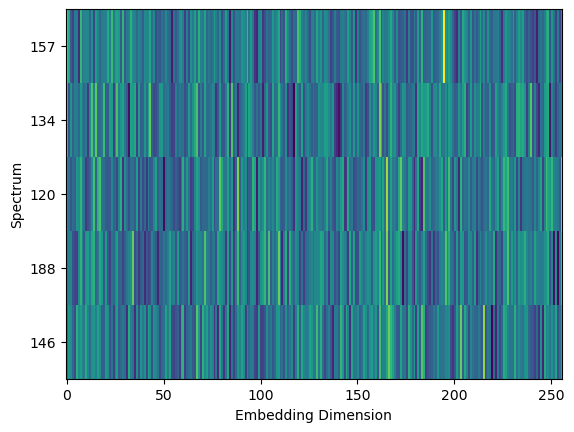

In [14]:
# Plot heatmap separating each row iwth boxes
plt.imshow(new_entry['embeds'], cmap="viridis", aspect="auto", interpolation="nearest")
# Set y tick labels
plt.yticks(range(len(new_entry['names'])), new_entry['names']);
plt.xlabel("Embedding Dimension")
plt.ylabel("Spectrum")

## Retrieval using contrastive FPs

This assumes we have predefined a list of candidate smiles.

See the scripts provided in quickstart that point to more efficient script implementations which use HDFs

In [15]:
new_labels = pd.read_csv(labels, sep="\t").astype(str)

In [16]:
# Contrastive embeddings
name_to_embed = {name: embed for name, embed in zip(new_entry['names'], new_entry['embeds'])}
name_to_formula = {name: formula for name, formula in zip(new_labels['spec'], new_labels['formula'])}

In [17]:
kwargs['mol_features'] = model.main_model.mol_features(mode="test")
kwargs['fp_names'] = contrast_model['hyper_parameters']['base_model_hparams']['fp_names']
paired_featurizer = featurizers.get_paired_featurizer(**kwargs)

In [18]:
# Extract candidate list file
smi_list = "../quickstart/lookup_smiles.txt"
all_smi = [i.strip() for i in open(smi_list, "r").readlines()]
forms = [utils.form_from_smi(i) for i in all_smi]
ikeys = [utils.inchikey_from_smiles(i) for i in all_smi]
form_to_smi = {i: [] for i in set(forms)}
for form, smi, ikey in zip(forms, all_smi, ikeys):
    form_to_smi[form].append((smi, ikey))

In [19]:
name_to_output = {}
for name, formula in name_to_formula.items():
    embed = name_to_embed[name]
    #print(name, formula, embed)
    candidates = form_to_smi[formula]
    print(name, formula, candidates)
    cand_smis, cand_ikeys = zip(*candidates)
    mol_list = [data.Mol.MolFromSmiles(i) for i in cand_smis]
    fp_list = [paired_featurizer.featurize_mol(i) for i in mol_list]
    fp_list = torch.from_numpy(np.vstack(fp_list)) 
    fp_loader = torch.utils.data.DataLoader(fp_list, batch_size=128, shuffle=False)
    encoded_mols = []
    with torch.no_grad():
            model = model.to(device)
            model = model.eval()
            for fp_batch in tqdm(fp_loader):
                batch = {"mols": fp_batch.to(device)}

                outputs = model.encode_mol(batch)
                contrast_out = outputs[1]["contrast"].detach().cpu()
                encoded_mols.append(contrast_out)
            stacked_mols = torch.cat(encoded_mols, 0).numpy()
    cos_dist = np.dot(embed, stacked_mols.T) / (np.linalg.norm(embed) * np.linalg.norm(stacked_mols, axis=1))
    arg_order = np.argsort(cos_dist)
    mol_list = np.array(cand_smis)[arg_order]
    name_to_output[name] = mol_list


157 C8H15NO4 [('CC(NC(C(=O)O)C(C)C)C(=O)O', 'MHWYRGPPKCKIQY-UHFFFAOYSA-N'), ('OC1CN2CCC(O)C2C(O)C1O', 'JDVVGAQPNNXQDW-UHFFFAOYSA-N'), ('CCCCC(O)C(O)=NCC(=O)O', 'YQMRIHFIEQHCOJ-UHFFFAOYSA-N'), ('CC(O)C(=O)NC(C(=O)O)C(C)C', 'IJKKTQLUXOILBQ-UHFFFAOYSA-N'), ('CCCCC(NCC(=O)O)C(=O)O', 'MBBNCIKYWHIZGN-UHFFFAOYSA-N'), ('CCC(O)CCC(O)=NCC(=O)O', 'MRWDIRTUXFYBHJ-UHFFFAOYSA-N'), ('C[N+](C)(C)C(CCC(=O)O)C(=O)[O-]', 'WTIGXLNNRAGPIV-UHFFFAOYSA-N'), ('CCCC(O)CC(O)=NCC(=O)O', 'AYNJYFWPCLXDNL-UHFFFAOYSA-N'), ('CC(C)(C)OC(=O)CC(N)C(=O)O', 'MXWMFBYWXMXRPD-UHFFFAOYSA-N'), ('CC(O)CCCC(O)=NCC(=O)O', 'YAFMZZZZHXVTEJ-UHFFFAOYSA-N'), ('CN1C2CCC1(O)C(O)C(O)C2O', 'GZDWTPRPLBRISA-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 958.48it/s]


134 C9H18N2O4 [('CCC(C)C(N)C(=O)NC(CO)C(=O)O', 'TWVKGYNQQAUNRN-UHFFFAOYSA-N'), ('CC(C)CC(N)C(O)=NC(CO)C(=O)O', 'XGDCYUQSFDQISZ-UHFFFAOYSA-N'), ('CCCC(C)(COC(N)=O)COC(N)=O', 'NPPQSCRMBWNHMW-UHFFFAOYSA-N'), ('CC(C)CC(N)(NC(C)C(=O)O)C(=O)O', 'HZOQMZBZPWLKIO-UHFFFAOYSA-N'), ('CC(C)CC(NC(=O)C(N)CO)C(=O)O', 'NFDYGNFETJVMSE-UHFFFAOYSA-N'), ('CC(C)C(NC(=O)C(N)C(C)O)C(=O)O', 'CKHWEVXPLJBEOZ-UHFFFAOYSA-N'), ('NCCCCC(NCCC(=O)O)C(=O)O', 'UENLDOJJKXLRJI-UHFFFAOYSA-N'), ('CC(C)C(N=C(O)C(N)C(C)O)C(=O)O', 'CKHWEVXPLJBEOZ-UHFFFAOYSA-N'), ('NC(CCCC(N)C(=O)O)CCC(=O)O', 'ALXLJPPLHFRKEJ-UHFFFAOYSA-N'), ('CC(NCCCCC(N)C(=O)O)C(=O)O', 'XCYPSOHOIAZISD-UHFFFAOYSA-N'), ('CC(C)(CO)C(O)C(=O)NCCC(N)=O', 'AMMYIDAXRNSZSJ-UHFFFAOYSA-N'), ('CCC(C)C(NC(=O)C(N)CO)C(=O)O', 'BXLYSRPHVMCOPS-UHFFFAOYSA-N'), ('NC(CCCCNCCC(=O)O)C(=O)O', 'SPBWCBIQZFYDOE-UHFFFAOYSA-N'), ('CC(C)C(N)C(=O)NC(C(=O)O)C(C)O', 'GVRKWABULJAONN-UHFFFAOYSA-N'), ('CC(NC(CCCCN)C(=O)O)C(=O)O', 'ZZYYVZYAZCMNPG-UHFFFAOYSA-N'), ('CCC(CC)(COC(N)=O)COC(N)=O', 'VS

100%|██████████| 1/1 [00:00<00:00, 1321.04it/s]


120 C6H6N2O [('NC(=O)c1cccnc1', 'DFPAKSUCGFBDDF-UHFFFAOYSA-N'), ('ON=Cc1ccccn1', 'MTFJSAGADRTKCI-UHFFFAOYSA-N'), ('Nc1cccnc1C=O', 'QNJCRBZVUFRESB-UHFFFAOYSA-N'), ('NC(=O)c1ccncc1', 'VFQXVTODMYMSMJ-UHFFFAOYSA-N'), ('CC(=O)c1cnccn1', 'DBZAKQWXICEWNW-UHFFFAOYSA-N'), ('N=C(O)c1ccccn1', 'IBBMAWULFFBRKK-UHFFFAOYSA-N'), ('O=NCc1ccccn1', 'NZNHTKNELYIQNB-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 2222.74it/s]


188 C6H6N2O2 [('[O-][N+](=NO)c1ccccc1', 'PTPLXVHPKMTVIW-UHFFFAOYSA-N'), ('N#CCCn1ccc(=O)o1', 'DNSSEQBYSHSUGR-UHFFFAOYSA-N'), ('NC(=O)c1ccc[n+]([O-])c1', 'USSFUVKEHXDAPM-UHFFFAOYSA-N'), ('O=C(O)C=Cc1c[nH]cn1', 'LOIYMIARKYCTBW-UHFFFAOYSA-N'), ('NC(=O)c1cnccc1O', 'UDTVJEZIOILIRG-UHFFFAOYSA-N'), ('Nc1ccc([N+](=O)[O-])cc1', 'TYMLOMAKGOJONV-UHFFFAOYSA-N'), ('O=C(NO)c1cccnc1', 'IYCHDNQCHLMLJZ-UHFFFAOYSA-N'), ('Cc1cnc(C(=O)O)cn1', 'RBYJWCRKFLGNDB-UHFFFAOYSA-N'), ('O=[N+]([O-])Nc1ccccc1', 'VBEGHXKAFSLLGE-UHFFFAOYSA-N'), ('Nc1ncccc1C(=O)O', 'KPIVDNYJNOPGBE-UHFFFAOYSA-N'), ('Nc1cccnc1C(=O)O', 'BOOMHTFCWOJWFO-UHFFFAOYSA-N'), ('Nc1cccc(ON=O)c1', 'HGFVJSMTWKYHDQ-UHFFFAOYSA-N'), ('NC(=O)c1ccc(=O)[nH]c1', 'NGPNYDVHEUXWIA-UHFFFAOYSA-N'), ('Nc1cccc([N+](=O)[O-])c1', 'XJCVRTZCHMZPBD-UHFFFAOYSA-N'), ('O=C(O)C=Cc1cnc[nH]1', 'LOIYMIARKYCTBW-UHFFFAOYSA-N'), ('NC(=O)n1ccccc1=O', 'IZDSWWYQJKEPQW-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1859.18it/s]


146 C7H7NO3 [('O=C(NO)c1ccccc1O', 'HBROZNQEVUILML-UHFFFAOYSA-N'), ('NOc1ccccc1C(=O)O', 'NBGAYCYFNGPNPV-UHFFFAOYSA-N'), ('Nc1ccc(C(=O)O)c(O)c1', 'WUBBRNOQWQTFEX-UHFFFAOYSA-N'), ('Cc1cc(O)ccc1[N+](=O)[O-]', 'PIIZYNQECPTVEO-UHFFFAOYSA-N'), ('COc1ccc(C(=O)O)cn1', 'NVDJVEQITUWZDT-UHFFFAOYSA-N'), ('Nc1ccc(O)c(C(=O)O)c1', 'KBOPZPXVLCULAV-UHFFFAOYSA-N'), ('Cc1ccc(O)c([N+](=O)[O-])c1', 'SYDNSSSQVSOXTN-UHFFFAOYSA-N'), ('Nc1cccc(C(=O)O)c1O', 'IQGMRVWUTCYCST-UHFFFAOYSA-N'), ('Nc1cc(O)cc(C(=O)O)c1', 'QPEJHSFTZVMSJH-UHFFFAOYSA-N'), ('Nc1cc(C(=O)O)ccc1O', 'MRBKRZAPGUCWOS-UHFFFAOYSA-N'), ('COc1ccc([N+](=O)[O-])cc1', 'BNUHAJGCKIQFGE-UHFFFAOYSA-N'), ('O=[N+]([O-])c1ccc(CO)cc1', 'JKTYGPATCNUWKN-UHFFFAOYSA-N'), ('NC(=O)C1=C(C=O)C=CCO1', 'JTLUWNHUNIMIFA-UHFFFAOYSA-N'), ('NC(=O)c1cc(O)ccc1O', 'FRXZIFVYTNMCHF-UHFFFAOYSA-N'), ('Nc1c(O)cccc1C(=O)O', 'WJXSWCUQABXPFS-UHFFFAOYSA-N')]


100%|██████████| 1/1 [00:00<00:00, 1954.48it/s]


Spectrum: 157 C8H15NO4


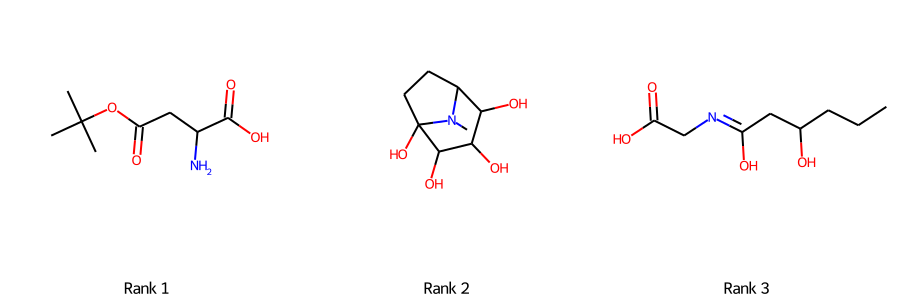




Spectrum: 134 C9H18N2O4


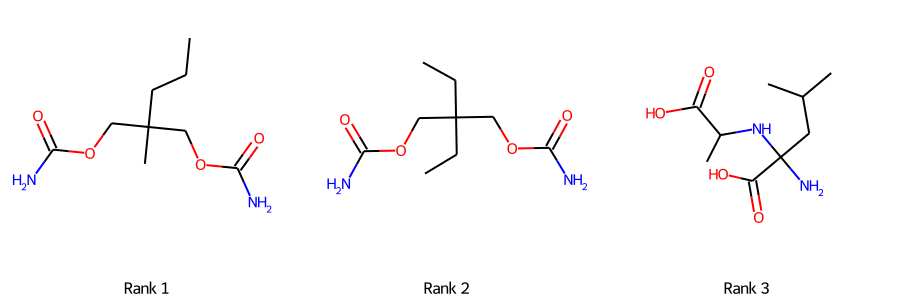




Spectrum: 120 C6H6N2O


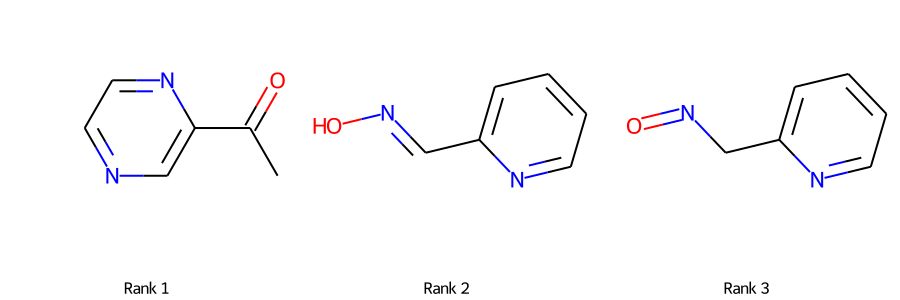




Spectrum: 188 C6H6N2O2


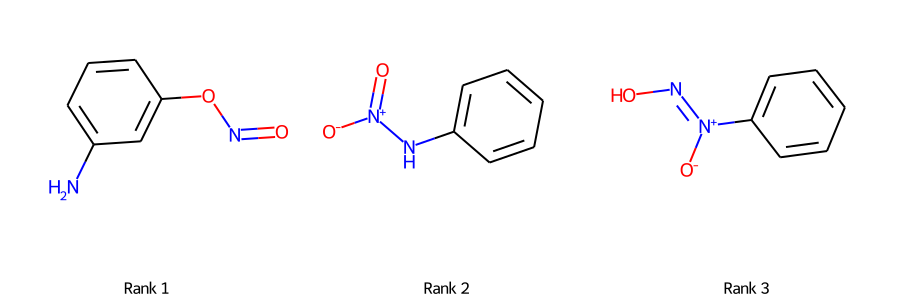




Spectrum: 146 C7H7NO3


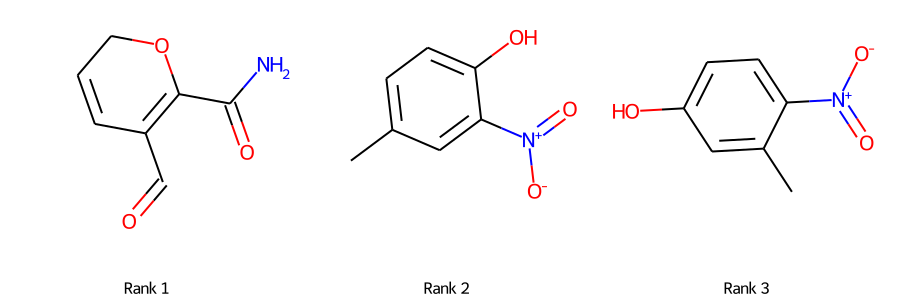

In [20]:
for k, v in name_to_output.items():
    # Print name and formula
    print(f"Spectrum: {k}", name_to_formula[k])
    # Display top 3 smiles using rdkit Chem mol to grid images
    if len(v) == 0:
        print("No cands for this formula")
        continue
    mol_objs = [Chem.MolFromSmiles(i) for i in v[:3]]
    # Add text below for rank
    img = Draw.MolsToGridImage(mol_objs, molsPerRow=3, subImgSize=(300, 300)
                                 , legends=[f"Rank {i+1}" for i in range(len(mol_objs))]
                               )
    display(img)
    print("\n\n")